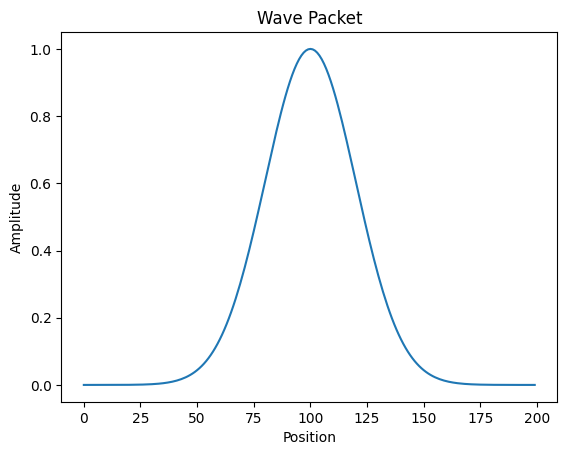

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wave_packet(array, peak_index, width=10):
    """
    Generate a wave packet with a peak of 1 at the specified index.

    Parameters:
        array (np.ndarray): Input 1D array.
        peak_index (int): The index where the peak of the wave packet should be.
        width (int): The width of the wave packet.

    Returns:
        np.ndarray: The generated wave packet.
    """
    length = len(array)
    x = np.arange(length)
    wave_packet = np.exp(-((x - peak_index) ** 2) / (2 * width ** 2))
    return wave_packet

# Example usage
if __name__ == "__main__":
    # Input 1D array
    input_array = np.zeros(200)  # Example array
    peak_index = 100  # Example peak index
    width = 20  # Example width

    # Generate wave packet
    wave_packet = generate_wave_packet(input_array, peak_index, width)

    # Plot the result
    plt.plot(wave_packet)
    plt.title("Wave Packet")
    plt.xlabel("Position")
    plt.ylabel("Amplitude")
    plt.show()
    

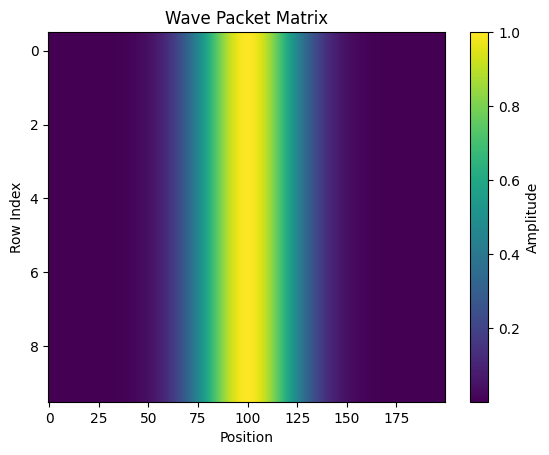

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from script.EnginConstraint.EC import EC

def generate_wave_packet_matrix(array, peak_index, width, n):
    """
    Generate a matrix where each row is a wave packet.

    Parameters:
        array (np.ndarray): Input 1D array.
        peak_index (int): The index where the peak of the wave packet should be.
        width (int): The width of the wave packet.
        n (int): The number of rows in the output matrix.

    Returns:
        np.ndarray: A matrix with `n` rows, each containing the wave packet.
    """
    # Generate the wave packet
    wave_packet = EC(array, peak_index, width)
    
    # Create a matrix by tiling the wave packet
    wave_packet_matrix = np.tile(wave_packet, (n, 1))
    return wave_packet_matrix

# Example usage
if __name__ == "__main__":
    # Input 1D array
    input_array = np.zeros(200)  # Example array
    peak_index = 100  # Example peak index
    width = 20  # Example width
    n = 10  # Number of rows in the matrix

    # Generate wave packet matrix
    wave_packet_matrix = generate_wave_packet_matrix(input_array, peak_index, width, n)

    # Plot the result
    plt.imshow(wave_packet_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label="Amplitude")
    plt.title("Wave Packet Matrix")
    plt.xlabel("Position")
    plt.ylabel("Row Index")
    plt.show()

In [1]:
import numpy as np
from scipy.optimize import minimize

def loss_function(L, C0, lambda_launch, k_mass, alpha, C_budget, w1, w2, w3, h_target, M_max, k_noise, T_obs):
    # Cost term
    C_cost = C0 + 3 * lambda_launch * k_mass * (L ** alpha)
    cost_term = w1 * (C_cost / C_budget)**2
    
    # Sensitivity performance term
    h_min = k_noise * np.sqrt(1 / (L**2 * T_obs))
    performance_term = w2 * (h_min / h_target)**2
    
    # Mass constraint term
    mass = k_mass * L**alpha
    mass_term = w3 * (mass / M_max)**2
    
    return cost_term + performance_term + mass_term

# 输入参数（示例）
params = {
    "C0": 1e9,          # 基础研发成本 (单位：美元)
    "lambda_launch": 2700,  # 发射成本 (美元/kg)
    "k_mass": 0.001,    # 质量系数 (kg/m^α)
    "alpha": 1.2,
    "C_budget": 2e9,    # 预算上限 (美元)
    "w1": 0.6, "w2": 0.3, "w3": 0.1,
    "h_target": 1e-21,  # 目标灵敏度 (应变单位)
    "M_max": 2000,      # 最大单星质量 (kg)
    "k_noise": 1e-22,   # 噪声系数 (Hz^-0.5)
    "T_obs": 1e8        # 观测时间 (秒)
}

# 优化求解
result = minimize(
    lambda L: loss_function(L[0], **params),
    x0=[1e9],           # 初始臂长 (米)
    bounds=[(0.5e9, 5e9)] # 臂长约束
)

print(f"Optimal arm length: {result.x[0]} meters")
print(f"Minimum loss value: {result.fun}")


Optimal arm length: 999999999.7610415 meters
Minimum loss value: 99566125.7710977


In [8]:
import numpy as np

# ==============================
# 核心函数定义
# ==============================

def payload_function(
    L: np.ndarray,
    k1: float = 1e6,
    k2: float = 1e4,
    k_m: float = 100,
    m0: float = 2000,
    C_max: float = 1.5e9,
    m_max: float = 5e3,
    S_ref: float = 1e-20,
    alpha: int = 2,
    w1: float = 0.4,
    w2: float = 0.3,
    w3: float = 0.3
) -> np.ndarray:
    """
    计算特定臂长下的总损失值

    参数:
    - L     : 臂长数组 (单位:米)
    - k*    : 技术参数（详见问题描述）
    - C_max : 预算成本上限 (单位:欧元)
    - m_max : 运载火箭最大承载质量 (单位:kg)
    - S_ref : 参考灵敏度阈值
    - alpha : 灵敏度与臂长的依赖关系指数
    - w*    : 权重系数

    返回值:
    - 总损失值数组,形状与输入L相同
    """
    # 计算成本 C(L)
    cost = k1 * L**2 + k2 * k_m * L
    
    # 计算卫星平台总质量 m(L)
    mass = k_m * L + m0
    
    # 假设灵敏度模型 S(L) ∝ 1/L^alpha
    S = 1 / (L**alpha)  # 简化的无量纲标度模型

    # 组合损失函数
    term_cost = w1 * (cost / C_max)          # 成本约束项
    term_mass = w2 * (mass / m_max)          # 质量约束项
    term_sense = -w3 * (S / S_ref)           # 灵敏度奖励项（负号表提高灵敏度为优）

    total_loss = term_cost + term_mass + term_sense
    return total_loss


# ==============================
# 数值实现：一维离散化与二维转换
# ==============================

def payload_matrix(n_row,L):
    """
    生成损失函数离散化后的二维矩阵

    参数:
    - n     : 臂长的采样点数
    - m     : 最终矩阵的列数
    - L_min : 臂长最小值 (单位:米)
    - L_max : 臂长最大值 (单位:米)

    返回:
    - L_1d : 一维臂长数组 (n,)
    - loss_matrix : 二维损失矩阵 (n, m)
    """
    # 生成一维臂长数组（均匀采样）
    #L_1d = np.linspace(L_min, L_max, n)
    
    # 计算对应的一维损失值
    loss_1d = payload_function(L)
    n= len(loss_1d)  # 一维数组长度
    # 将一维数组扩展为二维矩阵 (n, m)
    # 方法1：直接复制列（内存高效推荐）
    matrix = np.broadcast_to(
        loss_1d[:, np.newaxis],  # 转换为 (n,1)
        shape=(n, n_row)
    )
    
    # 方法2：等价但更显式的方式
    # loss_matrix = np.tile(loss_1d.reshape(-1,1), (1, m))
    
    return matrix


# ==============================
# 示例演示
# ==============================
if __name__ == "__main__":
    # 参数设置
    n_rows = 3    # 二维矩阵列数（示例较小值）
    L= np.array([1e9, 2e9, 3e9, 4e9])  # 示例臂长（单位:米）
    # 生成数据和矩阵
    mat = payload_matrix( n_rows,L)
    
    # 打印验证
    print("臂长一维样本数组（单位:1e9米）:")
    #print(np.round(L_sample / 1e9, 2))
    
    print("\n对应损失矩阵（前三项分别为成本项、质量项、灵敏度项的权重贡献）:")
    print(mat)


臂长一维样本数组（单位:1e9米）:

对应损失矩阵（前三项分别为成本项、质量项、灵敏度项的权重贡献）:
[[2.66666673e+14 2.66666673e+14 2.66666673e+14]
 [1.06666668e+15 1.06666668e+15 1.06666668e+15]
 [2.40000002e+15 2.40000002e+15 2.40000002e+15]
 [4.26666669e+15 4.26666669e+15 4.26666669e+15]]


In [10]:
data=np.array(np.loadtxt(r'/home/ljq/code/Multi-Obj-Opt2.0/Workspace/waveformAAK_PN5.txt'))

ValueError: the number of columns changed from 2 to 1 at row 586115; use `usecols` to select a subset and avoid this error

In [11]:
from scipy.optimize import brentq
import sys
sys.path.append('/home/ljq/code/MOO')
from config.config import config
from utils.zeropoint import *
from utils.Lumi_redshift import *
from utils.PSD import PSD_L_lambda
from utils.inner_prod import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft,fftfreq
import math
from scipy.signal.windows import tukey
from waveform.EMRI_waveform import *
import os
q=1e-4#mass ratio
M_final=10**5
itr=100000
e=0.1
   
    
# parameters
M = M_final
mu=M_final*q
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dt = 10
dist=1.0
T=0.5
h = few(M, mu, p0, e0, theta, phi,dist=dist, dt=dt, T=T)  
h=h.get()

wave1 = np.array(h)
f = np.array(np.arange(len(h))/dt/ len(h))  
#tukey_seq=np.array([tukey(i,len(h),1/8) for i in range(0,len(h))])
#print(len(wave1),len(tukey_seq))
wave1 *= tukey(len(h), 1/8)
waveform1 = fft(wave1)
waveform2 = np.column_stack((waveform1, f))
temp=waveform2.real*waveform2.real+waveform2.imag*waveform2.imag
waveform = np.sqrt(temp)

fseq=waveform[1:len(waveform[:,1]),1]
h_f=waveform[1:len(waveform[:,0]),0]
df=waveform[1,1]-waveform[0,1]
#将fseq还有h_f数据保存在/home/ljq/code/MOO/Object/SNR/EMRI并命名为FEW，数据格式使用科学计算中常用的格式
save_dir = "/home/ljq/code/MOO/Object/SNR/EMRI"
os.makedirs(save_dir, exist_ok=True)  # 确保目录存在
# 保存到 .npz 文件（推荐）
np.savez(os.path.join(save_dir, "FEW.npz"), freq=fseq, h_local=h_f)